# 用RNN进行时间序列预测


In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

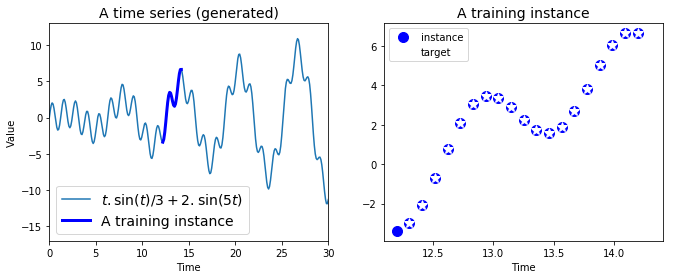

In [3]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

 
plt.show()

## 使用OutputProjectionWrapper

In [4]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,
                                              output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [5]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))  # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 1500
batch_size = 50
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "/tmp/time-series-data") 

0 	MSE: 19.772085
100 	MSE: 0.4531196
200 	MSE: 0.15698436
300 	MSE: 0.05528699
400 	MSE: 0.05178514
500 	MSE: 0.047824007
600 	MSE: 0.04897178
700 	MSE: 0.04987259
800 	MSE: 0.050523166
900 	MSE: 0.05551938
1000 	MSE: 0.042918667
1100 	MSE: 0.043405924
1200 	MSE: 0.050719943
1300 	MSE: 0.04084601
1400 	MSE: 0.04659339


INFO:tensorflow:Restoring parameters from /tmp/time-series-data


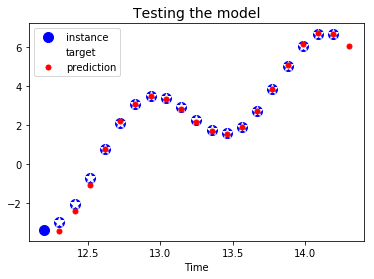

In [6]:
with tf.Session() as sess: 
    saver.restore(sess, "/tmp/time-series-data")
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## 不使用OutputProjectionWrapper

In [7]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) 
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))  # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 1500
batch_size = 50
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "/tmp/time-series-data") 

0 	MSE: 15.29193
100 	MSE: 0.47308847
200 	MSE: 0.17360653
300 	MSE: 0.089769855
400 	MSE: 0.054078393
500 	MSE: 0.05357524
600 	MSE: 0.0484104
700 	MSE: 0.06316046
800 	MSE: 0.043871228
900 	MSE: 0.044292577
1000 	MSE: 0.041127943
1100 	MSE: 0.04910887
1200 	MSE: 0.042817377
1300 	MSE: 0.037098035
1400 	MSE: 0.045980886


## 生成新的序列

INFO:tensorflow:Restoring parameters from /tmp/time-series-data


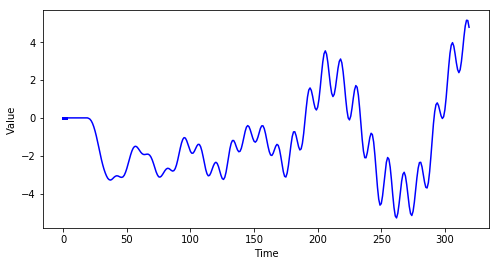

In [8]:
with tf.Session() as sess:                      
    saver.restore(sess, "/tmp/time-series-data")

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])
        
        
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from /tmp/time-series-data


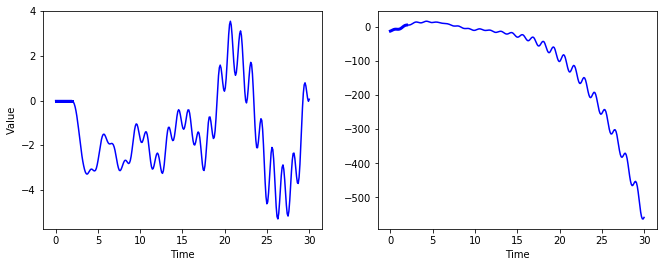

In [9]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/time-series-data")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()

## 多层RNN

In [10]:
tf.reset_default_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

X_batch = np.random.rand(2, n_steps, n_inputs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})
    print(outputs_val.shape)
    for state in states_val:
        print(state.shape)

(2, 5, 100)
(2, 100)
(2, 100)
(2, 100)


In [11]:
tf.reset_default_graph()
n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

n_layers = 3
neurons=[20, 50, 100]
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=neurons[layer])
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

X_batch = np.random.rand(2, n_steps, n_inputs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})
    print(outputs_val.shape)
    for state in states_val:
        print(state.shape)

(2, 5, 100)
(2, 20)
(2, 50)
(2, 100)
